# samplics: A Python Package for Complex Surveys 

##### <center> Mamadou S. Diallo, Ph.D., PStat <center>
##### <center> msdiallo@samplics.org / @MamadouSDiallo
##### <center> PyData, Cambridge Meetup, April 28th, 2021 <center>

### About me 

* Currently statistician at UNICEF 
* Senior statistician at Westat
* Mathematical statistician at Statistics Canada

Social media handles 
* Twitter / GitHub / LinkedIn: @MamadouSDiallo 

### Why Samplics ?

- No survey sampling package in Python, similar to R survey
- A comprehensive survey package... from selection to estimation in Python
- Allow Python users to stay in the Python ecosystem when analyzing survey data
- Help reduce the gap between official statistics and machine learning / data science

In [1]:
import warnings

warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

import samplics

##  American Community Survey (ACS) 2019

To illustrate the functionalities of *samplics*, we use a subset of the 2019 ACS sample from IPUMS [<sup id="ipums-usa">1</sup>](#ipumsusa).

**DISCLAIMER**
- The data used in this notebook is a non-representative subset of the 2019 ACS from IPUMS-USA (https://usa.ipums.org/usa/). 
- All the analyses in this notebook are only illustrations of the *samplis* functionalities and do not aim to produce representative estimates of the target population of the ACS 2019.
- Some variable names and values were relabeled to run the examples bellow. Also, variables categories were merged to simplify the examples.

**REFERENCE**<br>
[<sup id="ipums-usa">1</sup>](#ipumsusa) Steven Ruggles, Sarah Flood, Ronald Goeken, Josiah Grover, Erin Meyer, Jose Pacas and Matthew Sobek. IPUMS USA: Version 10.0 [dataset]. Minneapolis, MN: IPUMS, 2020. https://doi.org/10.18128/D010.V10.0

### Description of the 2019 ACS sample
- hhid: Household unique identification number
- state: State name
- psu: Primary sampling unit
- family_size: number of family members
- sex: sex of the head of the household
- age: age of the head of the household
- marital_status: marital status of the head of the household
- race: race of the head of the household
- citizen: US citizenship status of the head of the household
- speak_english: English speaking ability of the head of the household
- education: level of education
- food_stamp: Beneficiary status of the US Supplementary Nutrition Assistance Program (SNAP)
- family_income: total family income

In [2]:
# Read a subset of the 2019 ACS sample from IPUMS-USA
acs2019_head_hh = pd.read_csv("./acs2019_head_hh.csv")
acs2019_head_hh[
    [
        "hhid",
        "region",
        "psu",
        "sex",
        "race",
        "education",
        "family_income",
        "poverty",
    ]
].sample(15)

,hhid,region,psu,sex,race,education,family_income,poverty
229922,229923,Northeast,436,Male,White,No college,50000,0
225003,225004,Northeast,426,Female,White,No college,89100,0
796062,796063,Northeast,1465,Female,White,College,48400,0
454571,454572,Midwest,836,Male,White,College,94000,0
272616,272617,South,503,Male,White,No college,42600,0
485664,485665,South,891,Male,White,College,53600,0
624907,624908,Midwest,1138,Male,White,College,90500,0
976204,976205,Northeast,1795,Female,White,College,128000,0
980563,980564,Northeast,1803,Male,White,No college,130000,0
1142369,1142370,South,2103,Female,White,No college,13900,1


In [3]:
acs2019_head_hh.shape
acs2019_head_hh["psu"].drop_duplicates()

(1276716, 17)

0             1
454           2
1149          3
1799          4
2243          5
           ... 
1274264    2347
1274809    2348
1275207    2349
1275677    2350
1276221    2351
Name: psu, Length: 2351, dtype: int64

## Size Calculation

In [4]:
from samplics.sampling import SampleSize

# Expected poverty poverty rate
expected_pov_rate = {
    "Midwest": 0.11,
    "Northeast": 0.09,
    "South": 0.15,
    "West": 0.13,
}

# Declare the sample size calculation parameters
pov_rate_sample = SampleSize(
    parameter="proportion", method="wald", stratification=True
)

# calculate the sample size
pov_rate_sample.calculate(target=expected_pov_rate, half_ci=0.06)

# show the calculated sample size
pov_rate_sample.samp_size

{'Midwest': 105, 'Northeast': 88, 'South': 137, 'West': 121}

In [5]:
# Convert sample sizes to a pandas dataframe
pov_rate_sample.to_dataframe()

,_stratum,_target,_half_ci,_samp_size
0,Midwest,0.11,0.06,105.0
1,Northeast,0.09,0.06,88.0
2,South,0.15,0.06,137.0
3,West,0.13,0.06,121.0


In [6]:
psu_sample_size = {}
for key in pov_rate_sample.samp_size:
    psu_sample_size[key] = np.ceil(pov_rate_sample.samp_size[key] / 15).astype(
        int
    )

psu_sample_size

{'Midwest': 7, 'Northeast': 6, 'South': 10, 'West': 9}

## Selection

### PSU Selection

In [7]:
# Read the frame constructed from the subset of the 2019 ACS sample from IPUMS-USA
psu_frame = pd.read_csv("./psu_frame.csv")

In [8]:
# Constructed from the subset of the 2019 ACS sample from IPUMS-USA
psu_frame.sample(10).sort_values(by=["region", "state", "psu"])

,region,state,psu,number_households
71,Midwest,Illinois,776,479
285,Midwest,Minnesota,1164,219
454,Midwest,South Dakota,1891,737
769,Northeast,New York,1480,574
909,Northeast,Rhode Island,1855,497
925,South,Alabama,9,855
1264,South,Louisiana,946,447
1955,West,California,206,531
1977,West,California,228,609
2198,West,Montana,1244,755


In [9]:
from samplics.sampling import SampleSelection

stage1_design = SampleSelection(
    method="pps-sys", stratification=True, with_replacement=False
)

np.random.seed(12345)

(
    psu_frame["psu_sample"],
    psu_frame["psu_hits"],
    psu_frame["psu_probs"],
) = stage1_design.select(
    samp_unit=psu_frame["psu"],
    samp_size=psu_sample_size,
    stratum=psu_frame["region"],
    mos=psu_frame["number_households"],
    to_dataframe=False,
    sample_only=False,
)

psu_frame.sample(10)

,region,state,psu,number_households,psu_sample,psu_hits,psu_probs
1377,South,North Carolina,1564,519,0,0,0.010641
1612,South,Texas,2033,197,0,0,0.004039
1430,South,Oklahoma,1715,485,0,0,0.009944
414,Midwest,Ohio,1663,448,0,0,0.011145
838,Northeast,Pennsylvania,1784,615,0,0,0.016539
2238,West,Oregon,1730,710,0,0,0.022461
131,Midwest,Indiana,836,562,0,0,0.013981
302,Midwest,Missouri,1202,927,0,0,0.023062
1585,South,Texas,2006,453,0,0,0.009288
1815,West,Arizona,46,500,1,1,0.015818


In [10]:
# Return a pandas dataframe
selected_psus = psu_frame[["psu", "number_households"]].loc[
    psu_frame["psu_sample"].isin([1])
]
selected_psus.drop_duplicates(inplace=True)
selected_psus.head()

,psu,number_households
60,765,414
137,842,428
199,1078,1236
271,1150,295
349,1256,581


In [11]:
selected_psus.describe()

,psu,number_households
count,32.000000,32.000000
mean,1100.781250,603.218750
std,712.266565,198.980261
min,14.000000,295.000000
25%,474.250000,446.000000
50%,1114.000000,578.500000
75%,1686.000000,702.000000
max,2338.000000,1236.000000


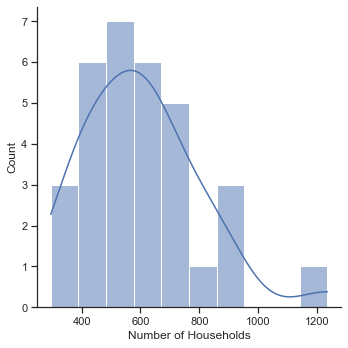

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("ticks")

ax= sns.displot(data=selected_psus, x="number_households", bins=10, kde=True)
ax.set(xlabel='Number of Households', ylabel='Count')

### Household Selection

In [13]:
household_frame = acs2019_head_hh.merge(selected_psus, on="psu")

In [14]:
household_frame[
    [
        "hhid",
        "region",
        "psu",
        "sex",
        "race",
        "education",
        "family_income",
        "poverty",
    ]
].head(15)

,hhid,region,psu,sex,race,education,family_income,poverty
0,8953,South,14,Female,White,College,136000,0
1,8954,South,14,Male,White,College,47800,0
2,8955,South,14,Female,White,No college,35000,0
3,8956,South,14,Male,White,No college,143330,0
4,8957,South,14,Female,White,No college,27800,0
5,8958,South,14,Female,White,No college,92000,0
6,8959,South,14,Male,White,No college,60000,0
7,8960,South,14,Female,White,College,102500,0
8,8961,South,14,Male,White,College,84000,0
9,8962,South,14,Female,White,College,52900,0


In [15]:
household_frame.shape

(19303, 18)

In [16]:
np.random.seed(12345)

stage2_design = SampleSelection(
    method="srs", stratification=True, with_replacement=False
)

household_sample = stage2_design.select(
    samp_unit=household_frame["hhid"],
    samp_size=15,
    stratum=household_frame["psu"],
    to_dataframe=True,
    sample_only=True,
)

household_sample.sample(5)

,_samp_unit,_stratum,_mos,_sample,_hits,_probs
424,1117740,2053,1.0,1,1,0.022523
383,986914,1813,1.0,1,1,0.029183
301,785576,1447,1.0,1,1,0.020080
341,841090,1553,1.0,1,1,0.027829
277,703166,1281,1.0,1,1,0.036320


## Weigthing

In [17]:
# Household sample
household_sample = household_sample[["_samp_unit", "_stratum", "_probs"]]
household_sample.columns = ["hhid", "psu", "hh_probs"]

household_sample

,hhid,psu,hh_probs
0,8958,14,0.024194
1,9018,14,0.024194
2,9067,14,0.024194
3,9079,14,0.024194
4,9138,14,0.024194
...,...,...,...
475,1271344,2338,0.024510
476,1271356,2338,0.024510
477,1271443,2338,0.024510
478,1271477,2338,0.024510


In [18]:
# psu_sample
psu_sample = psu_frame[["psu", "psu_probs"]].loc[
    psu_frame["psu_sample"].isin([1])
]
psu_sample.shape
household_sample = household_sample.merge(psu_sample, on="psu")
household_sample

(32, 2)

,hhid,psu,hh_probs,psu_probs
0,8958,14,0.024194,0.012712
1,9018,14,0.024194,0.012712
2,9067,14,0.024194,0.012712
3,9079,14,0.024194,0.012712
4,9138,14,0.024194,0.012712
...,...,...,...,...
475,1271344,2338,0.024510,0.015225
476,1271356,2338,0.024510,0.015225
477,1271443,2338,0.024510,0.015225
478,1271477,2338,0.024510,0.015225


In [19]:
# Probability of inclusion
household_sample["inclusion_probs"] = (
    household_sample["psu_probs"] * household_sample["hh_probs"]
)

# Base & Design weights
household_sample["design_weight"] = 1 / household_sample["inclusion_probs"]

In [20]:
household_sample

,hhid,psu,hh_probs,psu_probs,inclusion_probs,design_weight
0,8958,14,0.024194,0.012712,0.000308,3251.640000
1,9018,14,0.024194,0.012712,0.000308,3251.640000
2,9067,14,0.024194,0.012712,0.000308,3251.640000
3,9079,14,0.024194,0.012712,0.000308,3251.640000
4,9138,14,0.024194,0.012712,0.000308,3251.640000
...,...,...,...,...,...,...
475,1271344,2338,0.024510,0.015225,0.000373,2679.761905
476,1271356,2338,0.024510,0.015225,0.000373,2679.761905
477,1271443,2338,0.024510,0.015225,0.000373,2679.761905
478,1271477,2338,0.024510,0.015225,0.000373,2679.761905


In [21]:
household_sample = acs2019_head_hh.merge(household_sample, on=["psu", "hhid"])

In [22]:
# Data collection gives us the response status
household_sample["response_status"] = np.random.choice(
    a=["respondent", "non-respondent", "ineligible", "unknown"],
    p=(0.80, 0.15, 0.03, 0.02),
    size=household_sample.shape[0],
)

household_sample.head()

,hhid,region,state,psu,sex,age,hh_size,nb_children,marital_status,race,...,education,food_stamp,family_size,family_income,poverty,hh_probs,psu_probs,inclusion_probs,design_weight,response_status
0,8958,South,Alabama,14,Female,58,2,0,Married,White,...,No college,1,2,92000,0,0.024194,0.012712,0.000308,3251.64,respondent
1,9018,South,Alabama,14,Female,67,3,1,Divorced,White,...,No college,1,3,15200,1,0.024194,0.012712,0.000308,3251.64,respondent
2,9067,South,Alabama,14,Male,51,1,0,Divorced,White,...,No college,1,1,100000,0,0.024194,0.012712,0.000308,3251.64,respondent
3,9079,South,Alabama,14,Male,33,5,2,Married,White,...,College,1,4,72700,0,0.024194,0.012712,0.000308,3251.64,respondent
4,9138,South,Alabama,14,Female,64,1,0,Widowed,White,...,No college,1,1,37200,0,0.024194,0.012712,0.000308,3251.64,ineligible


In [23]:
from samplics.weighting import SampleWeight

response_status_mapping = {
    "in": "ineligible",
    "rr": "respondent",
    "nr": "non-respondent",
    "uk": "unknown",
}

household_sample["nr_weight"] = SampleWeight().adjust(
    samp_weight=household_sample["design_weight"],
    adjust_class=household_sample[["region", "race"]],
    resp_status=household_sample["response_status"],
    resp_dict=response_status_mapping,
    unknown_to_inelig=False,
)

In [24]:
household_sample[
    ["hhid", "region", "race", "response_status", "design_weight", "nr_weight"]
].sample(15)

,hhid,region,race,response_status,design_weight,nr_weight
459,1219200,West,Indian/Native,respondent,2107.318519,2107.318519
60,133899,West,White,respondent,2107.318519,2622.440823
343,841208,South,White,respondent,3251.640000,3895.832830
191,417382,Midwest,White,respondent,2679.761905,3366.880342
455,1219025,West,White,respondent,2107.318519,2622.440823
385,986935,Northeast,White,respondent,2478.966667,2784.070256
64,134000,West,White,respondent,2107.318519,2622.440823
104,197343,West,Other,non-respondent,2107.318519,0.000000
160,358130,South,White,respondent,3251.640000,3895.832830
457,1219131,West,Indian/Native,respondent,2107.318519,2107.318519


In [25]:
census_households = {
    "Midwest": 3700,
    "Northeast": 1500,
    "South": 2800,
    "West": 6500,
}

household_sample["ps_weight"] = SampleWeight().poststratify(
    samp_weight=household_sample["nr_weight"],
    control=census_households,
    domain=household_sample["region"],
)

In [26]:
household_sample

,hhid,region,state,psu,sex,age,hh_size,nb_children,marital_status,race,...,family_size,family_income,poverty,hh_probs,psu_probs,inclusion_probs,design_weight,response_status,nr_weight,ps_weight
0,8958,South,Alabama,14,Female,58,2,0,Married,White,...,2,92000,0,0.024194,0.012712,0.000308,3251.640000,respondent,3895.832830,22.364780
1,9018,South,Alabama,14,Female,67,3,1,Divorced,White,...,3,15200,1,0.024194,0.012712,0.000308,3251.640000,respondent,3895.832830,22.364780
2,9067,South,Alabama,14,Male,51,1,0,Divorced,White,...,1,100000,0,0.024194,0.012712,0.000308,3251.640000,respondent,3895.832830,22.364780
3,9079,South,Alabama,14,Male,33,5,2,Married,White,...,4,72700,0,0.024194,0.012712,0.000308,3251.640000,respondent,3895.832830,22.364780
4,9138,South,Alabama,14,Female,64,1,0,Widowed,White,...,1,37200,0,0.024194,0.012712,0.000308,3251.640000,ineligible,3251.640000,18.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1271344,Midwest,Wisconsin,2338,Male,64,2,0,Married,White,...,2,111200,0,0.024510,0.015225,0.000373,2679.761905,ineligible,2679.761905,35.238095
476,1271356,Midwest,Wisconsin,2338,Female,26,2,0,Single,White,...,2,75000,0,0.024510,0.015225,0.000373,2679.761905,respondent,3366.880342,44.273504
477,1271443,Midwest,Wisconsin,2338,Male,48,4,2,Married,White,...,4,70000,0,0.024510,0.015225,0.000373,2679.761905,respondent,3366.880342,44.273504
478,1271477,Midwest,Wisconsin,2338,Male,68,1,0,Widowed,White,...,1,77700,0,0.024510,0.015225,0.000373,2679.761905,respondent,3366.880342,44.273504


In [27]:
acs2019_head_hh[["region", "poverty", "nb_children"]].groupby("region").sum()

,poverty,nb_children
region,,
Midwest,31414,138952
Northeast,23280,102614
South,64056,239165
West,32131,154986


In [28]:
totals_by_domain = {
    "Midwest": {"poverty": 31414, "nb_children": 138952},
    "Northeast": {"poverty": 23280, "nb_children": 102614},
    "South": {"poverty": 64056, "nb_children": 239165},
    "West": {"poverty": 32131, "nb_children": 154986},
}

household_sample["calib_weight"] = SampleWeight().calibrate(
    samp_weight=household_sample["nr_weight"],
    aux_vars=household_sample[["poverty", "nb_children"]],
    control=totals_by_domain,
    domain=household_sample["region"],
)

In [29]:
test_calib = household_sample[["region"]]

test_calib["poverty_weighted"] = (
    household_sample["poverty"] * household_sample["calib_weight"]
)
test_calib["nb_children_weighted"] = (
    household_sample["nb_children"] * household_sample["calib_weight"]
)

test_calib[["region", "poverty_weighted", "nb_children_weighted"]].groupby(
    "region"
).sum().reset_index()

,region,poverty_weighted,nb_children_weighted
0,Midwest,31414.0,138952.0
1,Northeast,23280.0,102614.0
2,South,64056.0,239165.0
3,West,32131.0,154986.0


In [30]:
household_sample[
    [
        "hhid",
        "region",
        "race",
        "response_status",
        "design_weight",
        "calib_weight",
    ]
].sample(15)

,hhid,region,race,response_status,design_weight,calib_weight
406,1068887,South,White,respondent,3251.640000,3895.832830
277,703166,Northeast,Black,respondent,2478.966667,2641.203621
87,165715,West,White,respondent,2107.318519,2622.440823
455,1219025,West,White,respondent,2107.318519,2622.440823
338,841053,South,White,respondent,3251.640000,3233.350688
201,457655,Midwest,Asian,respondent,2679.761905,3573.015873
122,260577,South,White,respondent,3251.640000,3895.832830
354,905582,Midwest,White,non-respondent,2679.761905,0.000000
372,939112,West,White,respondent,2107.318519,2622.440823
251,631203,Midwest,White,respondent,2679.761905,3366.880342


## Estimation

In [31]:
resp_sample = household_sample.loc[
    household_sample["response_status"].isin(["respondent"]),
    [
        "hhid",
        "region",
        "psu",
        "sex",
        "race",
        "marital_status",
        "poverty",
        "calib_weight",
    ],
].copy()
resp_sample.sample(25)

,hhid,region,psu,sex,race,marital_status,poverty,calib_weight
302,785610,Northeast,1447,Male,White,Married,0,2966.274836
388,987039,Northeast,1813,Male,Asian,Single,0,3470.553333
81,165606,West,307,Female,White,Married,0,2622.440823
411,1069101,South,1955,Male,White,Divorced,1,3442.661323
375,986602,Northeast,1813,Female,White,Divorced,0,2784.070256
470,1271155,Midwest,2338,Female,White,Married,0,3332.198767
212,527389,South,967,Male,White,Married,0,3454.178069
476,1271356,Midwest,2338,Female,White,Single,0,3366.880342
335,840922,South,1553,Male,White,Widowed,0,3895.832830
344,841383,South,1553,Female,White,Divorced,1,3221.833942


In [32]:
resp_sample.to_csv("./resp_sample.csv", index=False)

In [33]:
from samplics.estimation import TaylorEstimator

poverty_rate = TaylorEstimator(parameter="proportion")

poverty_rate.estimate(
    y=resp_sample["poverty"],
    samp_weight=resp_sample["calib_weight"],
    stratum=resp_sample["region"],
    psu=resp_sample["psu"],
)

print(poverty_rate)

SAMPLICS - Estimation of Proportion

Number of strata: 4
Number of psus: 32
Degree of freedom: 28

 LEVELS  PROPORTION      SE      LCI      UCI       CV
      0    0.881327 0.02047 0.832597 0.917281 0.023227
      1    0.118673 0.02047 0.082719 0.167403 0.172492


## T-test

In [35]:
from samplics.categorical import Ttest

poverty_by_sex = Ttest(samp_type="one-sample")
poverty_by_sex.compare(
    y=resp_sample["poverty"],
    group=resp_sample["sex"],
    samp_weight=resp_sample["calib_weight"],
    stratum=resp_sample["region"],
    psu=resp_sample["psu"],
)

print(poverty_by_sex)


Design-based One-Sample T-test
 Null hypothesis (Ho): mean(Female) = mean(Male) 
 Equal variance assumption:
  t statictics: 0.6148
  Degrees of freedom: 391.00
  Alternative hypothesis (Ha):
   Prob(T < t) = 0.7305
   Prob(|T| > |t|) = 0.5390
   Prob(T > t) = 0.2695
 Unequal variance assumption:
  t statictics: 0.6076
  Degrees of freedom: 332.94
  Alternative hypothesis (Ha):
   Prob(T < t) = 0.7281
   Prob(|T| > |t|) = 0.5438
   Prob(T > t) = 0.2719 

 Group  Nb. Obs     Mean  Std. Error  Std. Dev.  Lower CI  Upper CI
Female      203 0.128885    0.019332   0.275437  0.089285  0.168484
  Male      190 0.107717    0.028981   0.399481  0.048351  0.167082

